# Model discovery from multiple experiments

## ICs variations

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.4'

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
from time import time


from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import shuffle,resample
from sklearn.linear_model import Ridge

import jax
from jax import random, numpy as jnp
from flax import optim
from flax.core import freeze, unfreeze

import sys
sys.path.append('pdeX')
from sparsity_estimators import ir_cond,ir_condAL, get_mask_multi
from DeepModx import pdeX, create_update_state, loss_fn_pinn_multi2, mse_test, mask_scheduler, Logger, Convergence


from time import time

%load_ext autoreload
%autoreload 2

# General params

In [2]:
key = random.PRNGKey(42)
np.random.seed(42)

In [3]:
# Data
noise_level = 0.1
number_of_samples = 2000
path = 'logs/ICs_GL' # path to log tensorboard files

vL=[0.1]
vICs=['','_pICs','_sICs']

u = []
scale_in = []
for viscosity in vL:
    for ICs in vICs:
        filename = '_n_'+str(number_of_samples)+'_100v_'+str(int(viscosity*100))
        
        x     = np.load('data/burgers'+ICs+'_x'+filename+'.npy')
        x = x-x[0]
        t     = np.load('data/burgers'+ICs+'_t'+filename+'.npy')
        t = t-t[0]
        u1     = np.array(np.load('data/burgers'+ICs+'_u'+filename+'.npy'),dtype=np.float32).reshape(len(x),len(t))
        
        scale_in.append([x.max(),t.max()])
        u.append(u1)

u = np.array(u)
n_out = len(u)

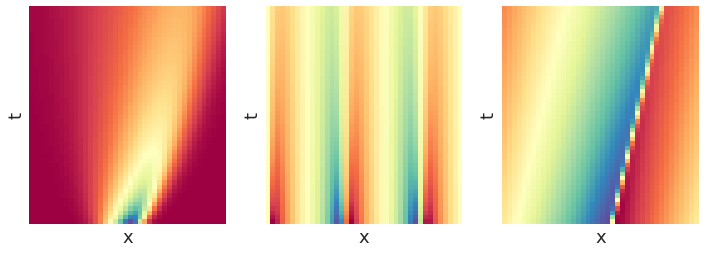

In [4]:
fig,ax = plt.subplots(1,3, figsize=(12,4))

for i in range(n_out):
    bx = sns.heatmap(u[i].T,ax=ax[i],cmap='Spectral',cbar=False)
    bx.invert_yaxis()    
    bx.set_xticks([])
    bx.set_yticks([])

    ax[i].set_xlabel('x')
    ax[i].set_ylabel('t');

In [5]:
# DeepMod parameters

# sparsity estimator
randomized = True
sparsity_method = 'GL'

# neural net architecture
nn_shared_features = []
nn_specific_features = [65,65,65,65,1]

# learning parameters
deltaSP = 1e-5 # target MSE on test set before triggering sparsity for the first time
deltaC = 1e-2  # converge criterion
learning_rate = 5e-5
max_epochs = 1e5+1

# logging
write_tensorboard = True

# Input data with some noise

In [6]:
un = []
for ui in u:
    un.append(ui + noise_level*np.std(ui)*np.random.randn(ui.shape[0],ui.shape[1]))

In [7]:
x_grid,  t_grid = jnp.meshgrid(x,  t, indexing="ij")

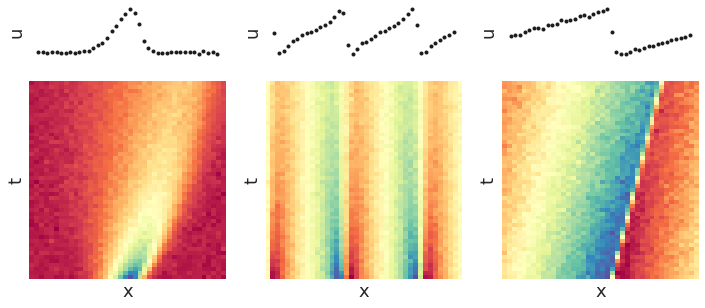

In [8]:


fig,ax = plt.subplots(2,3, figsize=(12,5),gridspec_kw={'height_ratios': [0.25, 1]})


for i in range(3):
    
        
    ax[0,i].plot(un[i].T[0,:],'.k',linewidth=3)
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[0,i].spines['top'].set_visible(False)
    ax[0,i].spines['right'].set_visible(False)
    ax[0,i].spines['bottom'].set_visible(False)
    ax[0,i].spines['left'].set_visible(False)
    
    #ax[0,i].set_xlabel('x')
    ax[0,i].set_ylabel('u');

    
    bx = sns.heatmap(un[i].T,ax=ax[1,i],cmap='Spectral',cbar=False)
    bx.invert_yaxis()    
    bx.set_xticks([])
    bx.set_yticks([])

    ax[1,i].set_xlabel('x')
    ax[1,i].set_ylabel('t');

In [9]:
X_data = jnp.concatenate([(t_grid/t.max()).reshape(-1, 1), (x_grid/x.max()).reshape(-1, 1)], axis=1)

In [10]:
y_data = []
scale_from_outputs = []
for uni in un:
    y_data.append((uni/uni.max()).reshape(-1, 1))#[idx])
    scale_from_outputs.append(uni.max())
y_data = jnp.array(y_data)[:,:,0].T

In [11]:
print(X_data.shape)
print(y_data.shape)

(2000, 2)
(2000, 3)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, shuffle= True)

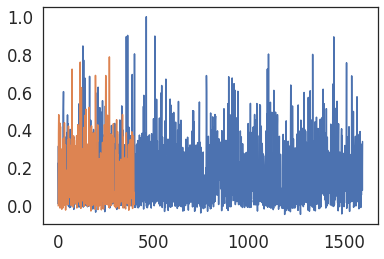

In [13]:
plt.plot(y_train[:,0])
plt.plot(y_test[:,0])

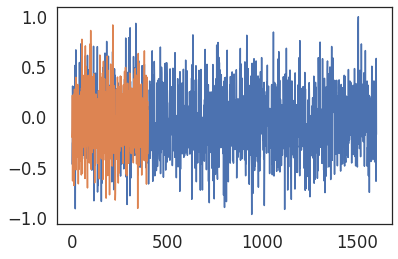

In [14]:
plt.plot(y_train[:,1])
plt.plot(y_test[:,1])

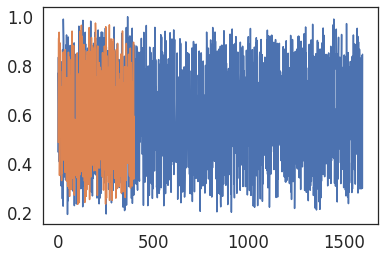

In [15]:
plt.plot(y_train[:,2])
plt.plot(y_test[:,2])

# Model initialization and parameters

In [16]:
# Instantiating model and optimizers
model = pdeX(nn_shared_features, nn_specific_features, n_out)
optimizer = optim.Adam(learning_rate=learning_rate, beta1=0.99, beta2=0.99)
logger = Logger(path)
converged = Convergence(delta=deltaC)

In [17]:
sparsity_scheduler = [mask_scheduler(delta=deltaSP) for i in range(n_out)]
sparsity_scheduler_group = mask_scheduler(delta=deltaSP)

In [18]:
# initializing
variables = model.init(key, X_train)
state, params = variables.pop('params')
y, updated_state = model.apply(variables, X_train, mutable=['coeffs_mask'])
optimizer = optimizer.create(params)
# compiling train step
update = create_update_state(loss_fn_pinn_multi2, model=model, x=X_train, y=y_train)
_ = update(optimizer, state)  # triggering compilation

# Training 

In [19]:

t_start = time()
counter = 0
for epoch in jnp.arange(max_epochs):

    # updating the model
    (optimizer, state), metrics, dt, theta, coeffs, coeffs_mask = update(optimizer, state)
    if epoch % 500 == 0:
        print(f"Loss step {epoch}: {metrics['mse']}")
    
    if epoch % 25 == 0:   

        # computing losses on test set, masks are set individually
        loss_test, loss_test_exp_wise = mse_test(model, optimizer.target, state, X_test, y_test)
        loss_test_metric = {'loss_test':loss_test_exp_wise}
        
        
        if write_tensorboard:
            metrics = {**metrics, **loss_test_metric}
            logger.write(metrics, epoch)


        update_sparsity, optimizer = sparsity_scheduler_group(loss_test, epoch, optimizer)
        # Loss on test set has increased, triggering the update of the mask
        if update_sparsity:
            ############################################################################################
            ############################################################################################
            if counter == 0:
                np.save(path +'/theta_IN',theta)
                np.save(path +'/dt_IN',dt)
                counter = 1
                print('sparsity at ', epoch)

            # computing new state to feed model
            mask,maxP_selec = get_mask_multi(theta,dt,method=sparsity_method,randomized=randomized)    
            more_metrics = {'prob_selec':maxP_selec}
            logger.write(more_metrics, epoch)

            ############################################################################################
            ############################################################################################

            state = freeze({'coeffs_mask': {'maskC': jnp.array(mask)}})
        
        if converged(epoch, coeffs):
            print(f'Converged at epoch {epoch}')

            np.save(path +'/theta_FIN',theta)
            np.save(path +'/dt_FIN',dt)

            break

logger.close()
t_end = time()
print(t_end - t_start)

############################################################################################
############################################################################################                    

Loss step 0.0: 0.5957659482955933
Loss step 500.0: 0.0026311385445296764
Loss step 1000.0: 0.0016453958814963698
Loss step 1500.0: 0.0016290920320898294
Loss step 2000.0: 0.001617330010049045
Loss step 2500.0: 0.0016058182809501886
sparsity at  2875.0
Loss step 3000.0: 0.0024772065225988626
Loss step 3500.0: 0.0016814792761579156
Loss step 4000.0: 0.001651042839512229
Loss step 4500.0: 0.0016432462725788355
Loss step 5000.0: 0.0016347758937627077
Loss step 5500.0: 0.0016293225344270468
Loss step 6000.0: 0.0016246349550783634
Loss step 6500.0: 0.0016201341059058905
Loss step 7000.0: 0.0016157188219949603
Loss step 7500.0: 0.001611405168659985
Loss step 8000.0: 0.0016070050187408924
Converged at epoch 8225.0
554.6831285953522


In [20]:
new_params = optimizer.target
new_variables = freeze({'params': new_params.unfreeze(), **state.unfreeze()})
uu_train = model.apply(new_variables,X_train,mutable=['coeffs_mask'])[0]
coeffs = uu_train[3]

# Resulting DeepMod data interpolations

In [21]:
def X_new(nx,nt):
    x1 = jnp.linspace(x.min(), x.max(), nx)
    t1 = jnp.linspace(t.min(), t.max(), nt)    
    t_grid, x_grid = jnp.meshgrid(t1, x1, indexing="ij")
    Xnn = jnp.concatenate([(t_grid/t.max()).reshape(-1, 1), (x_grid/x.max()).reshape(-1, 1)], axis=1)

    return Xnn

nx = 100
nt = 100
uu = model.apply(new_variables, X_new(nx,nt), mutable=list(state.keys()))[0]

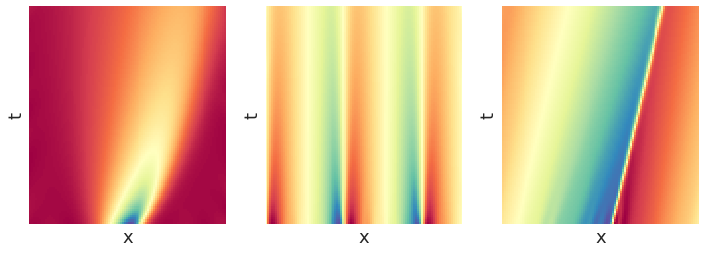

In [22]:
fig,ax = plt.subplots(1,3, figsize=(12,4))

for i in range(n_out):
    bx = sns.heatmap(uu[0][:,i].reshape(nt,nx)*scale_from_outputs[i],ax=ax[i],cmap='Spectral',cbar=False)
    bx.invert_yaxis()    
    bx.set_xticks([])
    bx.set_yticks([])

    ax[i].set_xlabel('x')
    ax[i].set_ylabel('t');

# Library and recovered PDEs

In [23]:
name_feats = ['1',
r'$u_x$',
r'$u_{xx}$',
r'$u_{xxx}$',
r'$u_{xxxx}$',
r'$u_{xxxxx}$',
r'$u$',
r'$uu_x$',
r'$uu_{xx}$',
r'$uu_{xxx}$',
r'$uu_{xxxx}$',
r'$uu_{xxxxx}$',
r'$u^2$',
r'$u^2u_x$',
r'$u^2u_{xx}$',
r'$u^2u_{xxx}$',
r'$u^2u_{xxxx}$',
r'$u^2u_{xxxxx}$',
r'$u^3$',
r'$u^3u_x$',
r'$u^3u_{xx}$',
r'$u^3u_{xxx}$',
r'$u^3u_{xxxx}$',
r'$u^3u_{xxxxx}$',
r'$u^4$',
r'$u^4u_x$',
r'$u^4u_{xx}$',
r'$u^4u_{xxx}$',
r'$u^4u_{xxxx}$',
r'$u^4u_{xxxxx}$',
r'$u^5$',
r'$u^5u_x$',
r'$u^5u_{xx}$',
r'$u^5u_{xxx}$',
r'$u^5u_{xxxx}$',
r'$u^5u_{xxxxx}$']

In [24]:
xi = coeffs[:,:,0]

In [25]:

xiS = []
xiS2 = []

for i, vCoeff in enumerate(xi):


    xmax = scale_in[i][0]
    tmax = scale_in[i][1]
    
    scaleX = np.tile(np.array([1,xmax,xmax**2,xmax**3,xmax**4,xmax**5]),6)
    scaleUT = scale_from_outputs[i]/tmax
    
    
    scaleU1 = np.tile(np.array(1/scale_from_outputs[i]),36)
    scaleU1[0] = 1
    
    scaleU2 = np.repeat(np.array([1,1/scale_from_outputs[i],1/scale_from_outputs[i]**2,1/scale_from_outputs[i]**3,1/scale_from_outputs[i]**4,1/scale_from_outputs[i]**5]),6)
    
    xiS.append( vCoeff * scaleUT * scaleX *  scaleU1 * scaleU2)
    
    
    
    A = uu_train[2][i]
    y = uu_train[1][i]

    sol = np.linalg.lstsq(A[:,[2,7]], y, rcond=None)
    xiS2.append( sol[0].ravel() * scaleUT * scaleX[[2,7]] *  scaleU1[[2,7]] * scaleU2[[2,7]])

    
    
xiS = np.array(xiS).T
xiS

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.09937251,  0.09876027,  0.09922168],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.99400914, -0.97838068, -1.00731503],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   